In [36]:
from __future__ import print_function, division
import time
import torch
import pickle
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader, random_split
from data_classes import RNASeqDataset, LocalEnergyOpt
# from my_script import get_target, loss_fn, train, test
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [37]:
# CUDA for Pytorch
print(torch.cuda.is_available())
# device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device ='cpu'

True


In [38]:
def get_target(X):
    if len(X['features'].shape) == 2:
        X['features'] = X['features'].unsqueeze(0)
    target = (X['features'][:,0:3,9])
    return target


# Functions without gradients in the loss

def loss_fn(energy,target):
    batch_size = energy.shape[0]
    loss = (energy - target).pow(2).sum() / batch_size
    return loss


def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    model.train()
    train_loss = 0
    for X in tqdm(dataloader):
        pred = model(X)
        target = get_target(X)
        loss = loss_fn(pred, target)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= num_batches
    print(f'Avg train_loss = {train_loss:>0.4f}, batches = {num_batches}')
    return train_loss


def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X in tqdm(dataloader):
            pred = model(X)
            target = get_target(X)
            loss = loss_fn(pred, target)
            test_loss += loss.item()
    test_loss /= num_batches
    print(f'Avg test_loss = {test_loss:>0.4f}, batches = {num_batches}')
    return test_loss

In [39]:
# Parameters
params = {'batch_size': 16,
      'shuffle': True,
      'num_workers': 0,
      'pin_memory': False}
epochs = 300

In [41]:
# Datasets and Dataloaders
seq_data = RNASeqDataset(device=device)
print(f'dataset allocated on {device}')

tot_length = len(seq_data)
test_length = int(0.2*tot_length)
train_set, test_set = random_split(seq_data, [tot_length - test_length, test_length]) #, generator=torch.Generator().manual_seed(42))
print(f'Training set: {len(train_set)} elements')
print(f'Test set: {len(test_set)} elements')

dataset allocated on cpu
Training set: 1311 elements
Test set: 327 elements


In [53]:
# Model and optimizer
fixed_pars = pickle.load(open('data/SeqCSV/fixed_pars.p', 'rb'))
opt_pars = pickle.load(open('data/SeqCSV/pars.p', 'rb'))

# set parameters to the same order of magnitude, but different from 1
fixed_pars['bond_type'][:,0] /= 100
fixed_pars['angle_type'][:,0] /= 100

model = LocalEnergyOpt(fixed_pars,opt_pars,device,set_to_one=False).to(device)
# torch.save(model.state_dict(), 'data/Results/initial_values.pth')
# model.load_state_dict(torch.load("data/Results/model_pars.pth"))
# model.load_state_dict(torch.load("data/Results/try_batch16.npy"))

lr = 1e-7
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=500, cooldown=1000, threshold=1e-12, verbose=True)
my_loss = loss_fn  # _with_grad
my_train = train  # _with_grad
my_test = test  # _with_grad

for p in model.parameters():
      print(p)

Parameter containing:
tensor([  2.6080,   2.0730,   1.5190,   2.3550,   4.1900,   4.6980,   4.8240,
          5.6360,   2.1300,   1.3070,  15.2230,   1.0000,   2.8000,   2.5050,
          1.8260,   3.9320,   4.3090,   4.7750,   4.5460,   2.8210,   3.8130,
          3.0100,   0.9080,   3.0000,   4.0000,   2.2570,   0.4800,   0.5000,
          4.2470,  10.8160,  11.1210,   5.8190,   0.5010,   0.7300,   0.3310,
          0.2570,   0.2240,   0.2070,   1.2000,   1.5000,   0.4000,   1.8000,
          0.8000, 142.3060,   1.0000,   0.0000,   1.4830], requires_grad=True)
Parameter containing:
tensor([[ 0.3000,  3.8000],
        [ 2.0000,  2.3440],
        [ 2.0000,  2.6220],
        [ 2.0000,  2.6330],
        [ 2.0000,  3.0620],
        [ 2.0000,  3.0040],
        [ 2.0000,  2.4500],
        [ 2.0000,  2.1800],
        [ 2.0000,  1.5200],
        [ 2.0000,  1.5930],
        [ 2.0000,  1.4300],
        [ 0.4000, 12.0000],
        [ 0.1000, 12.0000],
        [ 0.1000, 12.0000],
        [ 0.1000,

## Execution time and loss as function of batch size

In [66]:
batch_size_list = [1,2,4,8,16,32,64,128,256,512]
times = []
final_train_loss = []
final_test_loss = []
epochs = 5
for batch_size in batch_size_list:
      print('batch size = %i' %batch_size)
      params['batch_size'] = batch_size
      print(params)
      train_dataloader = DataLoader(train_set,**params)
      test_dataloader = DataLoader(test_set,**params)
      model.load_state_dict(torch.load("data/Results/initial_values.pth"))
      t0 = time.time()
      for i in range(epochs):
            print(f'epoch {i+1}/{epochs} \n-------------------------')
            train_tmp = my_train(train_dataloader, model, my_loss, optimizer)
            test_tmp = my_test(test_dataloader, model, my_loss)
      tf = time.time()
      times.append((tf-t0)/epochs)
      final_train_loss.append(train_tmp)
      final_test_loss.append(test_tmp)
print(times)
print(final_train_loss)
print(final_test_loss)

batch size = 1
{'batch_size': 1, 'shuffle': True, 'num_workers': 0, 'pin_memory': False}
epoch 1/5 
-------------------------


 48%|████▊     | 625/1311 [00:01<00:01, 418.02it/s]


KeyboardInterrupt: 

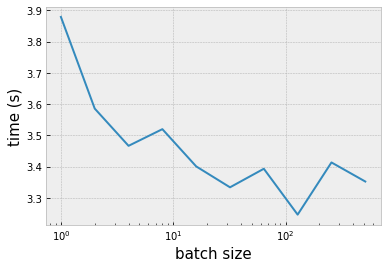

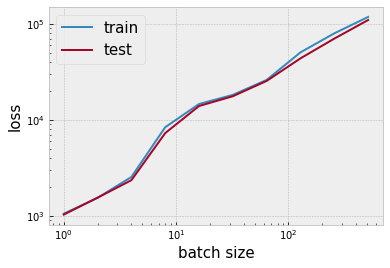

In [30]:
# Plots


plt.semilogx(batch_size_list, times)
plt.xlabel('batch size',fontsize=15)
plt.ylabel('time (s)',fontsize=15)
plt.savefig('Images/batch_time.pdf')
plt.show()

plt.loglog(batch_size_list,final_train_loss,label='train')
plt.loglog(batch_size_list,final_test_loss,label='test')
plt.xlabel('batch size',fontsize=15)
plt.ylabel('loss',fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Images/batch_loss.pdf')
plt.show()

In [8]:
for p in model.parameters():
    print(p.data)

tensor([  2.6080,   2.0730,   1.5190,   2.3550,   4.1900,   4.6980,   4.8240,
          5.6360,   2.1300,   1.3070,  15.2230,   1.0000,   2.8000,   2.5050,
          1.8260,   3.9320,   4.3090,   4.7750,   4.5460,   2.8210,   3.8130,
          3.0100,   0.9080,   3.0000,   4.0000,   2.2570,   0.4800,   0.5000,
          4.2470,  10.8160,  11.1210,   5.8190,   0.5010,   0.7300,   0.3310,
          0.2570,   0.2240,   0.2070,   1.2000,   1.5000,   0.4000,   1.8000,
          0.8000, 142.3060,   1.0000,   0.0000,   1.4830])
tensor([[ 30.0000,   3.8000],
        [200.0000,   2.3440],
        [200.0000,   2.6220],
        [200.0000,   2.6330],
        [200.0000,   3.0620],
        [200.0000,   3.0040],
        [200.0000,   2.4500],
        [200.0000,   2.1800],
        [200.0000,   1.5200],
        [200.0000,   1.5930],
        [200.0000,   1.4300],
        [ 40.0000,  12.0000],
        [ 10.0000,  12.0000],
        [ 10.0000,  12.0000],
        [ 10.0000,  12.0000]])
tensor([[ 70.0000,   2

In [54]:
train_loss = []
test_loss = []
epochs = 400
params = {'batch_size': 8,
      'shuffle': True,
      'num_workers': 0,
      'pin_memory': False}
train_dataloader = DataLoader(train_set,**params)
test_dataloader = DataLoader(test_set,**params)
# model.load_state_dict(torch.load("data/Results/initial_values.pth"))

for index_epoch in range(epochs):
    print(f'epoch {index_epoch+1}/{epochs} \n-------------------------')
    t0 = time.time()
    train_tmp = my_train(train_dataloader, model, my_loss, optimizer)
    test_tmp = my_test(test_dataloader, model, my_loss)
    tf = time.time()
    print(f'time for epoch: {tf-t0} \n')
    train_loss.append(train_tmp)
    test_loss.append(test_tmp)

for p in model.parameters():
    print(p.data)

torch.save(model.state_dict(), 'data/Results/400_b8_same_order.pth')

epoch 1/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 62.28it/s]


Avg train_loss = 19753.0396, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.27it/s]


Avg test_loss = 18559.9592, batches = 41
time for epoch: 3.0995841026306152 

epoch 2/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.56it/s]


Avg train_loss = 17090.8771, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.68it/s]


Avg test_loss = 15828.5071, batches = 41
time for epoch: 3.0042800903320312 

epoch 3/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.41it/s]


Avg train_loss = 14260.3258, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.17it/s]


Avg test_loss = 13004.1770, batches = 41
time for epoch: 3.0125749111175537 

epoch 4/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.65it/s]


Avg train_loss = 11438.4697, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.94it/s]


Avg test_loss = 10270.9394, batches = 41
time for epoch: 3.0338048934936523 

epoch 5/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.25it/s]


Avg train_loss = 8842.4176, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.98it/s]


Avg test_loss = 7867.1456, batches = 41
time for epoch: 3.0150082111358643 

epoch 6/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.56it/s]


Avg train_loss = 6679.7404, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.29it/s]


Avg test_loss = 5959.1605, batches = 41
time for epoch: 3.000622034072876 

epoch 7/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.79it/s]


Avg train_loss = 5064.3395, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.90it/s]


Avg test_loss = 4598.9965, batches = 41
time for epoch: 2.988412380218506 

epoch 8/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.59it/s]


Avg train_loss = 3975.4417, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.69it/s]


Avg test_loss = 3715.3611, batches = 41
time for epoch: 2.992511510848999 

epoch 9/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.80it/s]


Avg train_loss = 3306.5634, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.46it/s]


Avg test_loss = 3182.4371, batches = 41
time for epoch: 2.9854278564453125 

epoch 10/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.63it/s]


Avg train_loss = 2916.9903, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.02it/s]


Avg test_loss = 2862.1545, batches = 41
time for epoch: 2.99937105178833 

epoch 11/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.83it/s]


Avg train_loss = 2684.3346, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.34it/s]


Avg test_loss = 2665.6553, batches = 41
time for epoch: 2.98464035987854 

epoch 12/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.77it/s]


Avg train_loss = 2533.4148, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.59it/s]


Avg test_loss = 2527.0952, batches = 41
time for epoch: 3.0362157821655273 

epoch 13/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 62.72it/s]


Avg train_loss = 2423.4937, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.23it/s]


Avg test_loss = 2421.7675, batches = 41
time for epoch: 3.070535182952881 

epoch 14/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.30it/s]


Avg train_loss = 2332.7376, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.66it/s]


Avg test_loss = 2327.9516, batches = 41
time for epoch: 3.0092554092407227 

epoch 15/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.09it/s]


Avg train_loss = 2247.1226, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.98it/s]


Avg test_loss = 2239.3375, batches = 41
time for epoch: 3.0158445835113525 

epoch 16/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 60.85it/s]


Avg train_loss = 2166.7029, batches = 164


100%|██████████| 41/41 [00:00<00:00, 87.11it/s]


Avg test_loss = 2158.4138, batches = 41
time for epoch: 3.1721513271331787 

epoch 17/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 62.29it/s]


Avg train_loss = 2085.1693, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.00it/s]


Avg test_loss = 2075.3479, batches = 41
time for epoch: 3.0947461128234863 

epoch 18/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.21it/s]


Avg train_loss = 2005.2804, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.74it/s]


Avg test_loss = 1990.8540, batches = 41
time for epoch: 3.0223772525787354 

epoch 19/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 61.71it/s]


Avg train_loss = 1924.6885, batches = 164


100%|██████████| 41/41 [00:00<00:00, 87.24it/s]


Avg test_loss = 1910.0726, batches = 41
time for epoch: 3.1342270374298096 

epoch 20/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 62.63it/s]


Avg train_loss = 1843.2526, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.39it/s]


Avg test_loss = 1827.0630, batches = 41
time for epoch: 3.0734353065490723 

epoch 21/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.22it/s]


Avg train_loss = 1759.5815, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.28it/s]


Avg test_loss = 1742.0800, batches = 41
time for epoch: 3.059629201889038 

epoch 22/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.13it/s]


Avg train_loss = 1675.1238, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.76it/s]


Avg test_loss = 1656.5629, batches = 41
time for epoch: 3.020379066467285 

epoch 23/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.03it/s]


Avg train_loss = 1590.2869, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.57it/s]


Avg test_loss = 1574.0407, batches = 41
time for epoch: 3.0661497116088867 

epoch 24/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.74it/s]


Avg train_loss = 1505.3390, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.11it/s]


Avg test_loss = 1487.3337, batches = 41
time for epoch: 3.0292959213256836 

epoch 25/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.90it/s]


Avg train_loss = 1421.0727, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.80it/s]


Avg test_loss = 1400.6308, batches = 41
time for epoch: 3.0240583419799805 

epoch 26/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.27it/s]


Avg train_loss = 1338.7014, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.70it/s]


Avg test_loss = 1319.5841, batches = 41
time for epoch: 3.0501277446746826 

epoch 27/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.68it/s]


Avg train_loss = 1259.8013, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.01it/s]


Avg test_loss = 1240.9417, batches = 41
time for epoch: 3.0075345039367676 

epoch 28/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.79it/s]


Avg train_loss = 1186.0210, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.83it/s]


Avg test_loss = 1167.6272, batches = 41
time for epoch: 3.0333690643310547 

epoch 29/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.71it/s]


Avg train_loss = 1117.1297, batches = 164


100%|██████████| 41/41 [00:00<00:00, 76.77it/s]


Avg test_loss = 1101.5066, batches = 41
time for epoch: 3.1148409843444824 

epoch 30/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.80it/s]


Avg train_loss = 1055.3671, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.18it/s]


Avg test_loss = 1044.4542, batches = 41
time for epoch: 2.9820618629455566 

epoch 31/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.13it/s]


Avg train_loss = 1000.3735, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.21it/s]


Avg test_loss = 995.0477, batches = 41
time for epoch: 2.9787192344665527 

epoch 32/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.37it/s]


Avg train_loss = 952.9276, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.97it/s]


Avg test_loss = 946.5996, batches = 41
time for epoch: 3.010014057159424 

epoch 33/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.95it/s]


Avg train_loss = 912.2790, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.84it/s]


Avg test_loss = 909.8631, batches = 41
time for epoch: 2.9825735092163086 

epoch 34/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.95it/s]


Avg train_loss = 878.2099, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.39it/s]


Avg test_loss = 877.2693, batches = 41
time for epoch: 3.024186134338379 

epoch 35/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 62.30it/s]


Avg train_loss = 848.9989, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.60it/s]


Avg test_loss = 848.5073, batches = 41
time for epoch: 3.096565008163452 

epoch 36/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.90it/s]


Avg train_loss = 824.6671, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.43it/s]


Avg test_loss = 826.2211, batches = 41
time for epoch: 2.9864039421081543 

epoch 37/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.75it/s]


Avg train_loss = 803.5740, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.05it/s]


Avg test_loss = 806.5745, batches = 41
time for epoch: 2.989356756210327 

epoch 38/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.56it/s]


Avg train_loss = 785.4587, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.33it/s]


Avg test_loss = 791.1630, batches = 41
time for epoch: 3.010741949081421 

epoch 39/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 61.98it/s]


Avg train_loss = 770.0280, batches = 164


100%|██████████| 41/41 [00:00<00:00, 87.41it/s]


Avg test_loss = 773.9428, batches = 41
time for epoch: 3.121891975402832 

epoch 40/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.27it/s]


Avg train_loss = 755.8749, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.24it/s]


Avg test_loss = 762.6000, batches = 41
time for epoch: 3.048370361328125 

epoch 41/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.19it/s]


Avg train_loss = 742.7433, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.81it/s]


Avg test_loss = 750.6952, batches = 41
time for epoch: 3.012915849685669 

epoch 42/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.99it/s]


Avg train_loss = 730.9752, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.03it/s]


Avg test_loss = 737.7621, batches = 41
time for epoch: 3.0197525024414062 

epoch 43/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.46it/s]


Avg train_loss = 720.6648, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.54it/s]


Avg test_loss = 726.6884, batches = 41
time for epoch: 2.9985673427581787 

epoch 44/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.71it/s]


Avg train_loss = 709.9595, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.09it/s]


Avg test_loss = 717.2865, batches = 41
time for epoch: 2.9857749938964844 

epoch 45/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.57it/s]


Avg train_loss = 700.3711, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.96it/s]


Avg test_loss = 706.5857, batches = 41
time for epoch: 2.9966163635253906 

epoch 46/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.08it/s]


Avg train_loss = 690.8209, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.46it/s]


Avg test_loss = 698.4398, batches = 41
time for epoch: 2.9696638584136963 

epoch 47/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.24it/s]


Avg train_loss = 682.6220, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.99it/s]


Avg test_loss = 688.6299, batches = 41
time for epoch: 2.9659416675567627 

epoch 48/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.87it/s]


Avg train_loss = 674.3455, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.07it/s]


Avg test_loss = 680.6218, batches = 41
time for epoch: 2.984668254852295 

epoch 49/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.25it/s]


Avg train_loss = 666.0589, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.43it/s]


Avg test_loss = 674.2343, batches = 41
time for epoch: 2.983053207397461 

epoch 50/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.78it/s]


Avg train_loss = 657.9747, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.49it/s]


Avg test_loss = 666.1423, batches = 41
time for epoch: 2.986269950866699 

epoch 51/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.84it/s]


Avg train_loss = 650.6220, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.67it/s]


Avg test_loss = 659.6710, batches = 41
time for epoch: 2.9781341552734375 

epoch 52/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.88it/s]


Avg train_loss = 643.3756, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.94it/s]


Avg test_loss = 653.6737, batches = 41
time for epoch: 2.980036497116089 

epoch 53/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.85it/s]


Avg train_loss = 636.6257, batches = 164


100%|██████████| 41/41 [00:00<00:00, 93.00it/s]


Avg test_loss = 644.7773, batches = 41
time for epoch: 2.975747585296631 

epoch 54/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.15it/s]


Avg train_loss = 629.7219, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.69it/s]


Avg test_loss = 639.4051, batches = 41
time for epoch: 2.965719223022461 

epoch 55/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.03it/s]


Avg train_loss = 623.3295, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.00it/s]


Avg test_loss = 632.8842, batches = 41
time for epoch: 2.9738211631774902 

epoch 56/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.05it/s]


Avg train_loss = 617.2276, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.17it/s]


Avg test_loss = 629.7767, batches = 41
time for epoch: 2.972522258758545 

epoch 57/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.15it/s]


Avg train_loss = 612.1687, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.10it/s]


Avg test_loss = 620.5356, batches = 41
time for epoch: 2.973555564880371 

epoch 58/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.11it/s]


Avg train_loss = 605.2879, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.01it/s]


Avg test_loss = 615.5177, batches = 41
time for epoch: 2.9709367752075195 

epoch 59/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.25it/s]


Avg train_loss = 599.9552, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.53it/s]


Avg test_loss = 609.9584, batches = 41
time for epoch: 2.963059186935425 

epoch 60/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.01it/s]


Avg train_loss = 594.2278, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.33it/s]


Avg test_loss = 604.7093, batches = 41
time for epoch: 2.97324800491333 

epoch 61/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.25it/s]


Avg train_loss = 588.7473, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.87it/s]


Avg test_loss = 601.8671, batches = 41
time for epoch: 2.961408853530884 

epoch 62/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.87it/s]


Avg train_loss = 583.5255, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.50it/s]


Avg test_loss = 595.1726, batches = 41
time for epoch: 2.987644672393799 

epoch 63/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.89it/s]


Avg train_loss = 578.8286, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.41it/s]


Avg test_loss = 590.5731, batches = 41
time for epoch: 2.977785587310791 

epoch 64/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.45it/s]


Avg train_loss = 574.2291, batches = 164


100%|██████████| 41/41 [00:00<00:00, 86.27it/s]


Avg test_loss = 585.9848, batches = 41
time for epoch: 3.0267069339752197 

epoch 65/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 60.51it/s]


Avg train_loss = 568.9268, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.18it/s]


Avg test_loss = 582.7143, batches = 41
time for epoch: 3.1771116256713867 

epoch 66/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.02it/s]


Avg train_loss = 564.2481, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.29it/s]


Avg test_loss = 576.6738, batches = 41
time for epoch: 3.027125120162964 

epoch 67/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.73it/s]


Avg train_loss = 559.8260, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.46it/s]


Avg test_loss = 571.3893, batches = 41
time for epoch: 2.9984781742095947 

epoch 68/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.31it/s]


Avg train_loss = 555.5465, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.93it/s]


Avg test_loss = 567.2548, batches = 41
time for epoch: 3.012336015701294 

epoch 69/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.30it/s]


Avg train_loss = 551.1541, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.14it/s]


Avg test_loss = 563.5110, batches = 41
time for epoch: 3.0117485523223877 

epoch 70/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.53it/s]


Avg train_loss = 547.0219, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.48it/s]


Avg test_loss = 560.7054, batches = 41
time for epoch: 3.0058693885803223 

epoch 71/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.94it/s]


Avg train_loss = 543.0831, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.68it/s]


Avg test_loss = 555.3738, batches = 41
time for epoch: 3.028358221054077 

epoch 72/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.12it/s]


Avg train_loss = 538.8635, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.64it/s]


Avg test_loss = 550.8489, batches = 41
time for epoch: 3.0263397693634033 

epoch 73/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.95it/s]


Avg train_loss = 534.5840, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.54it/s]


Avg test_loss = 547.2429, batches = 41
time for epoch: 3.0239481925964355 

epoch 74/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.66it/s]


Avg train_loss = 530.7866, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.44it/s]


Avg test_loss = 544.0410, batches = 41
time for epoch: 3.0010931491851807 

epoch 75/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.38it/s]


Avg train_loss = 526.8702, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.27it/s]


Avg test_loss = 539.6944, batches = 41
time for epoch: 3.018239736557007 

epoch 76/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.27it/s]


Avg train_loss = 523.1527, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.59it/s]


Avg test_loss = 536.3849, batches = 41
time for epoch: 3.0108532905578613 

epoch 77/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.52it/s]


Avg train_loss = 519.4693, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.91it/s]


Avg test_loss = 534.7753, batches = 41
time for epoch: 3.0042080879211426 

epoch 78/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.23it/s]


Avg train_loss = 516.1614, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.20it/s]


Avg test_loss = 529.2408, batches = 41
time for epoch: 3.024218797683716 

epoch 79/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.52it/s]


Avg train_loss = 512.4913, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.84it/s]


Avg test_loss = 525.9344, batches = 41
time for epoch: 3.0447635650634766 

epoch 80/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.45it/s]


Avg train_loss = 508.9091, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.94it/s]


Avg test_loss = 522.0953, batches = 41
time for epoch: 3.0072078704833984 

epoch 81/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.34it/s]


Avg train_loss = 505.5406, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.66it/s]


Avg test_loss = 519.5172, batches = 41
time for epoch: 3.0136985778808594 

epoch 82/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.44it/s]


Avg train_loss = 502.1504, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.23it/s]


Avg test_loss = 515.7417, batches = 41
time for epoch: 3.011655807495117 

epoch 83/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.98it/s]


Avg train_loss = 498.7002, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.43it/s]


Avg test_loss = 513.0648, batches = 41
time for epoch: 3.029301643371582 

epoch 84/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.44it/s]


Avg train_loss = 495.4960, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.92it/s]


Avg test_loss = 509.9416, batches = 41
time for epoch: 3.0134172439575195 

epoch 85/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.94it/s]


Avg train_loss = 492.0767, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.58it/s]


Avg test_loss = 506.8598, batches = 41
time for epoch: 2.99069881439209 

epoch 86/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.17it/s]


Avg train_loss = 488.9203, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.13it/s]


Avg test_loss = 502.7766, batches = 41
time for epoch: 3.0180306434631348 

epoch 87/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.30it/s]


Avg train_loss = 485.6764, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.87it/s]


Avg test_loss = 499.8223, batches = 41
time for epoch: 3.014192581176758 

epoch 88/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.03it/s]


Avg train_loss = 482.5168, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.55it/s]


Avg test_loss = 496.8303, batches = 41
time for epoch: 3.0265052318573 

epoch 89/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.34it/s]


Avg train_loss = 479.4618, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.23it/s]


Avg test_loss = 493.6030, batches = 41
time for epoch: 3.0107944011688232 

epoch 90/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 62.90it/s]


Avg train_loss = 476.1792, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.77it/s]


Avg test_loss = 490.8061, batches = 41
time for epoch: 3.065385103225708 

epoch 91/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.05it/s]


Avg train_loss = 473.0030, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.28it/s]


Avg test_loss = 487.0890, batches = 41
time for epoch: 3.0157949924468994 

epoch 92/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.72it/s]


Avg train_loss = 470.1733, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.45it/s]


Avg test_loss = 485.0927, batches = 41
time for epoch: 3.0335590839385986 

epoch 93/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.97it/s]


Avg train_loss = 466.6383, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.46it/s]


Avg test_loss = 481.0012, batches = 41
time for epoch: 3.01847505569458 

epoch 94/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.64it/s]


Avg train_loss = 463.7167, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.68it/s]


Avg test_loss = 477.6715, batches = 41
time for epoch: 2.990402936935425 

epoch 95/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.72it/s]


Avg train_loss = 460.5508, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.68it/s]


Avg test_loss = 475.2087, batches = 41
time for epoch: 2.992542266845703 

epoch 96/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.07it/s]


Avg train_loss = 457.3856, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.13it/s]


Avg test_loss = 472.3542, batches = 41
time for epoch: 3.0110154151916504 

epoch 97/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.33it/s]


Avg train_loss = 454.9868, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.05it/s]


Avg test_loss = 469.0788, batches = 41
time for epoch: 3.005768060684204 

epoch 98/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.84it/s]


Avg train_loss = 451.0682, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.90it/s]


Avg test_loss = 465.6980, batches = 41
time for epoch: 2.9869699478149414 

epoch 99/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.39it/s]


Avg train_loss = 447.9688, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.22it/s]


Avg test_loss = 463.2214, batches = 41
time for epoch: 3.012698173522949 

epoch 100/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.70it/s]


Avg train_loss = 444.8833, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.23it/s]


Avg test_loss = 460.4712, batches = 41
time for epoch: 2.9905707836151123 

epoch 101/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.37it/s]


Avg train_loss = 441.8520, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.75it/s]


Avg test_loss = 457.0946, batches = 41
time for epoch: 3.000920534133911 

epoch 102/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.75it/s]


Avg train_loss = 438.7880, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.04it/s]


Avg test_loss = 454.1849, batches = 41
time for epoch: 2.994502067565918 

epoch 103/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.61it/s]


Avg train_loss = 435.5645, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.84it/s]


Avg test_loss = 449.9783, batches = 41
time for epoch: 3.0013532638549805 

epoch 104/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.88it/s]


Avg train_loss = 432.5460, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.95it/s]


Avg test_loss = 447.3589, batches = 41
time for epoch: 2.984663248062134 

epoch 105/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.02it/s]


Avg train_loss = 429.3736, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.01it/s]


Avg test_loss = 444.0629, batches = 41
time for epoch: 2.9791605472564697 

epoch 106/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.75it/s]


Avg train_loss = 426.0371, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.00it/s]


Avg test_loss = 440.7401, batches = 41
time for epoch: 2.9948699474334717 

epoch 107/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.70it/s]


Avg train_loss = 422.9426, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.03it/s]


Avg test_loss = 437.4698, batches = 41
time for epoch: 3.0015921592712402 

epoch 108/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.68it/s]


Avg train_loss = 419.7872, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.33it/s]


Avg test_loss = 434.6438, batches = 41
time for epoch: 2.991154193878174 

epoch 109/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.16it/s]


Avg train_loss = 416.5571, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.84it/s]


Avg test_loss = 431.3551, batches = 41
time for epoch: 2.974241256713867 

epoch 110/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.59it/s]


Avg train_loss = 413.1272, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.43it/s]


Avg test_loss = 427.3460, batches = 41
time for epoch: 2.9939098358154297 

epoch 111/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.86it/s]


Avg train_loss = 409.7830, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.29it/s]


Avg test_loss = 424.5363, batches = 41
time for epoch: 2.984076976776123 

epoch 112/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 62.57it/s]


Avg train_loss = 406.8739, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.46it/s]


Avg test_loss = 420.7977, batches = 41
time for epoch: 3.0755789279937744 

epoch 113/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.29it/s]


Avg train_loss = 403.3605, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.25it/s]


Avg test_loss = 417.8800, batches = 41
time for epoch: 3.0117995738983154 

epoch 114/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.83it/s]


Avg train_loss = 399.7551, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.02it/s]


Avg test_loss = 414.6400, batches = 41
time for epoch: 2.9865314960479736 

epoch 115/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.00it/s]


Avg train_loss = 396.5699, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.55it/s]


Avg test_loss = 410.6940, batches = 41
time for epoch: 2.9873366355895996 

epoch 116/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.99it/s]


Avg train_loss = 392.9437, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.32it/s]


Avg test_loss = 407.2379, batches = 41
time for epoch: 3.018008232116699 

epoch 117/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.20it/s]


Avg train_loss = 389.6013, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.07it/s]


Avg test_loss = 404.1340, batches = 41
time for epoch: 2.971606969833374 

epoch 118/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.03it/s]


Avg train_loss = 386.1578, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.37it/s]


Avg test_loss = 401.5127, batches = 41
time for epoch: 2.97216796875 

epoch 119/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.10it/s]


Avg train_loss = 382.6112, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.55it/s]


Avg test_loss = 396.6420, batches = 41
time for epoch: 2.9733340740203857 

epoch 120/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.20it/s]


Avg train_loss = 379.2054, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.28it/s]


Avg test_loss = 395.4914, batches = 41
time for epoch: 2.9708571434020996 

epoch 121/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 62.61it/s]


Avg train_loss = 375.7873, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.43it/s]


Avg test_loss = 389.9981, batches = 41
time for epoch: 3.079003095626831 

epoch 122/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.89it/s]


Avg train_loss = 372.1836, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.89it/s]


Avg test_loss = 386.5863, batches = 41
time for epoch: 2.9844939708709717 

epoch 123/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.53it/s]


Avg train_loss = 368.4620, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.77it/s]


Avg test_loss = 382.8634, batches = 41
time for epoch: 2.9996824264526367 

epoch 124/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.52it/s]


Avg train_loss = 364.9038, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.68it/s]


Avg test_loss = 380.4394, batches = 41
time for epoch: 2.995300769805908 

epoch 125/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.08it/s]


Avg train_loss = 361.4439, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.22it/s]


Avg test_loss = 375.7822, batches = 41
time for epoch: 2.975781202316284 

epoch 126/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.54it/s]


Avg train_loss = 358.0361, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.60it/s]


Avg test_loss = 372.2393, batches = 41
time for epoch: 2.9997003078460693 

epoch 127/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.74it/s]


Avg train_loss = 354.3314, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.24it/s]


Avg test_loss = 368.5631, batches = 41
time for epoch: 2.9936678409576416 

epoch 128/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.05it/s]


Avg train_loss = 350.8511, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.37it/s]


Avg test_loss = 365.1332, batches = 41
time for epoch: 2.976308584213257 

epoch 129/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.69it/s]


Avg train_loss = 347.4746, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.85it/s]


Avg test_loss = 361.3515, batches = 41
time for epoch: 2.997798204421997 

epoch 130/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.08it/s]


Avg train_loss = 343.7005, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.00it/s]


Avg test_loss = 358.6409, batches = 41
time for epoch: 3.0617802143096924 

epoch 131/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.29it/s]


Avg train_loss = 340.3472, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.52it/s]


Avg test_loss = 355.1995, batches = 41
time for epoch: 3.009850025177002 

epoch 132/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.33it/s]


Avg train_loss = 336.7736, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.93it/s]


Avg test_loss = 350.9106, batches = 41
time for epoch: 3.0114104747772217 

epoch 133/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.12it/s]


Avg train_loss = 333.2587, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.35it/s]


Avg test_loss = 347.4447, batches = 41
time for epoch: 3.02339768409729 

epoch 134/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.10it/s]


Avg train_loss = 329.7336, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.47it/s]


Avg test_loss = 344.2667, batches = 41
time for epoch: 3.0233590602874756 

epoch 135/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.89it/s]


Avg train_loss = 326.2240, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.42it/s]


Avg test_loss = 340.6422, batches = 41
time for epoch: 2.9873721599578857 

epoch 136/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.23it/s]


Avg train_loss = 322.9454, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.88it/s]


Avg test_loss = 337.0566, batches = 41
time for epoch: 3.0057342052459717 

epoch 137/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.82it/s]


Avg train_loss = 319.5800, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.32it/s]


Avg test_loss = 333.9371, batches = 41
time for epoch: 2.9851362705230713 

epoch 138/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 62.65it/s]


Avg train_loss = 316.2901, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.98it/s]


Avg test_loss = 330.7760, batches = 41
time for epoch: 3.0745296478271484 

epoch 139/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.27it/s]


Avg train_loss = 312.9273, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.49it/s]


Avg test_loss = 327.4734, batches = 41
time for epoch: 2.9719834327697754 

epoch 140/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.73it/s]


Avg train_loss = 309.7923, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.75it/s]


Avg test_loss = 324.4150, batches = 41
time for epoch: 2.9866623878479004 

epoch 141/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.93it/s]


Avg train_loss = 306.7506, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.86it/s]


Avg test_loss = 320.5667, batches = 41
time for epoch: 2.9830734729766846 

epoch 142/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.37it/s]


Avg train_loss = 303.5998, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.25it/s]


Avg test_loss = 317.1959, batches = 41
time for epoch: 3.0035407543182373 

epoch 143/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.41it/s]


Avg train_loss = 300.5196, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.55it/s]


Avg test_loss = 314.8979, batches = 41
time for epoch: 3.0053980350494385 

epoch 144/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.99it/s]


Avg train_loss = 297.4991, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.79it/s]


Avg test_loss = 311.3866, batches = 41
time for epoch: 3.015660524368286 

epoch 145/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.87it/s]


Avg train_loss = 294.6986, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.69it/s]


Avg test_loss = 308.9517, batches = 41
time for epoch: 2.986687421798706 

epoch 146/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.06it/s]


Avg train_loss = 291.8236, batches = 164


100%|██████████| 41/41 [00:00<00:00, 68.05it/s]


Avg test_loss = 306.1447, batches = 41
time for epoch: 3.169435739517212 

epoch 147/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.30it/s]


Avg train_loss = 289.0959, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.28it/s]


Avg test_loss = 303.7391, batches = 41
time for epoch: 3.0112016201019287 

epoch 148/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.81it/s]


Avg train_loss = 286.4735, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.18it/s]


Avg test_loss = 300.6282, batches = 41
time for epoch: 2.9915263652801514 

epoch 149/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.99it/s]


Avg train_loss = 283.8561, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.34it/s]


Avg test_loss = 298.0541, batches = 41
time for epoch: 2.978510856628418 

epoch 150/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.18it/s]


Avg train_loss = 281.2710, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.02it/s]


Avg test_loss = 295.2662, batches = 41
time for epoch: 2.977679967880249 

epoch 151/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.87it/s]


Avg train_loss = 278.8420, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.54it/s]


Avg test_loss = 292.7197, batches = 41
time for epoch: 2.987257242202759 

epoch 152/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.23it/s]


Avg train_loss = 276.4726, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.26it/s]


Avg test_loss = 290.8308, batches = 41
time for epoch: 2.969564199447632 

epoch 153/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.91it/s]


Avg train_loss = 274.1466, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.26it/s]


Avg test_loss = 289.0738, batches = 41
time for epoch: 2.9975972175598145 

epoch 154/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 62.80it/s]


Avg train_loss = 272.1255, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.87it/s]


Avg test_loss = 285.7488, batches = 41
time for epoch: 3.0789988040924072 

epoch 155/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.88it/s]


Avg train_loss = 269.9265, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.74it/s]


Avg test_loss = 283.7929, batches = 41
time for epoch: 2.9911446571350098 

epoch 156/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.77it/s]


Avg train_loss = 267.8292, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.49it/s]


Avg test_loss = 281.4461, batches = 41
time for epoch: 2.9865007400512695 

epoch 157/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.71it/s]


Avg train_loss = 265.7460, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.03it/s]


Avg test_loss = 279.5926, batches = 41
time for epoch: 2.996145009994507 

epoch 158/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.19it/s]


Avg train_loss = 264.0361, batches = 164


100%|██████████| 41/41 [00:00<00:00, 83.27it/s]


Avg test_loss = 278.5251, batches = 41
time for epoch: 3.094337224960327 

epoch 159/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 60.33it/s]


Avg train_loss = 262.1354, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.41it/s]


Avg test_loss = 275.9088, batches = 41
time for epoch: 3.183742046356201 

epoch 160/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 62.31it/s]


Avg train_loss = 260.3235, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.29it/s]


Avg test_loss = 274.1074, batches = 41
time for epoch: 3.097459554672241 

epoch 161/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.81it/s]


Avg train_loss = 258.6252, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.27it/s]


Avg test_loss = 272.8972, batches = 41
time for epoch: 3.031094789505005 

epoch 162/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.52it/s]


Avg train_loss = 256.9940, batches = 164


100%|██████████| 41/41 [00:00<00:00, 82.92it/s]


Avg test_loss = 271.0714, batches = 41
time for epoch: 3.0430102348327637 

epoch 163/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 61.18it/s]


Avg train_loss = 255.6210, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.96it/s]


Avg test_loss = 269.9207, batches = 41
time for epoch: 3.145537853240967 

epoch 164/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.76it/s]


Avg train_loss = 253.8469, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.05it/s]


Avg test_loss = 268.4622, batches = 41
time for epoch: 3.0289463996887207 

epoch 165/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.65it/s]


Avg train_loss = 252.5117, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.65it/s]


Avg test_loss = 266.3752, batches = 41
time for epoch: 2.98567271232605 

epoch 166/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 61.78it/s]


Avg train_loss = 251.0468, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.14it/s]


Avg test_loss = 264.8591, batches = 41
time for epoch: 3.106786012649536 

epoch 167/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 62.86it/s]


Avg train_loss = 249.6433, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.51it/s]


Avg test_loss = 263.3820, batches = 41
time for epoch: 3.0693979263305664 

epoch 168/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.53it/s]


Avg train_loss = 248.5292, batches = 164


100%|██████████| 41/41 [00:00<00:00, 86.89it/s]


Avg test_loss = 262.8226, batches = 41
time for epoch: 3.060727596282959 

epoch 169/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.62it/s]


Avg train_loss = 247.1687, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.79it/s]


Avg test_loss = 261.0079, batches = 41
time for epoch: 3.036864757537842 

epoch 170/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.11it/s]


Avg train_loss = 246.0945, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.72it/s]


Avg test_loss = 259.4933, batches = 41
time for epoch: 2.968125820159912 

epoch 171/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.69it/s]


Avg train_loss = 244.8552, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.55it/s]


Avg test_loss = 258.9745, batches = 41
time for epoch: 2.9950990676879883 

epoch 172/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.18it/s]


Avg train_loss = 243.8538, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.38it/s]


Avg test_loss = 257.4087, batches = 41
time for epoch: 2.9719061851501465 

epoch 173/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.92it/s]


Avg train_loss = 242.6575, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.80it/s]


Avg test_loss = 256.4338, batches = 41
time for epoch: 2.985003709793091 

epoch 174/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.71it/s]


Avg train_loss = 241.6558, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.69it/s]


Avg test_loss = 255.1050, batches = 41
time for epoch: 2.993642568588257 

epoch 175/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.15it/s]


Avg train_loss = 240.5759, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.25it/s]


Avg test_loss = 254.3351, batches = 41
time for epoch: 2.968790292739868 

epoch 176/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.51it/s]


Avg train_loss = 239.6258, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.06it/s]


Avg test_loss = 253.3090, batches = 41
time for epoch: 2.999897003173828 

epoch 177/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.10it/s]


Avg train_loss = 238.7947, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.58it/s]


Avg test_loss = 252.2625, batches = 41
time for epoch: 3.0131168365478516 

epoch 178/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.97it/s]


Avg train_loss = 238.0117, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.33it/s]


Avg test_loss = 251.4085, batches = 41
time for epoch: 2.9802894592285156 

epoch 179/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.84it/s]


Avg train_loss = 237.3880, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.02it/s]


Avg test_loss = 252.0112, batches = 41
time for epoch: 2.9818949699401855 

epoch 180/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.02it/s]


Avg train_loss = 236.0957, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.47it/s]


Avg test_loss = 249.9882, batches = 41
time for epoch: 2.972670078277588 

epoch 181/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.27it/s]


Avg train_loss = 235.3819, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.84it/s]


Avg test_loss = 248.8571, batches = 41
time for epoch: 2.9709830284118652 

epoch 182/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.21it/s]


Avg train_loss = 234.5641, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.39it/s]


Avg test_loss = 248.6452, batches = 41
time for epoch: 2.9707884788513184 

epoch 183/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.80it/s]


Avg train_loss = 233.7068, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.99it/s]


Avg test_loss = 247.1660, batches = 41
time for epoch: 2.988065242767334 

epoch 184/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.35it/s]


Avg train_loss = 232.8763, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.27it/s]


Avg test_loss = 246.3949, batches = 41
time for epoch: 3.014338254928589 

epoch 185/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.50it/s]


Avg train_loss = 232.3610, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.32it/s]


Avg test_loss = 245.7705, batches = 41
time for epoch: 3.00254487991333 

epoch 186/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.13it/s]


Avg train_loss = 231.4798, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.98it/s]


Avg test_loss = 245.0013, batches = 41
time for epoch: 3.024340867996216 

epoch 187/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.13it/s]


Avg train_loss = 230.6984, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.91it/s]


Avg test_loss = 244.1759, batches = 41
time for epoch: 3.024674654006958 

epoch 188/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.11it/s]


Avg train_loss = 230.0672, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.99it/s]


Avg test_loss = 243.4641, batches = 41
time for epoch: 3.0249643325805664 

epoch 189/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.31it/s]


Avg train_loss = 229.3403, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.20it/s]


Avg test_loss = 243.9911, batches = 41
time for epoch: 3.010960102081299 

epoch 190/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.02it/s]


Avg train_loss = 228.7173, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.95it/s]


Avg test_loss = 242.0337, batches = 41
time for epoch: 3.0289113521575928 

epoch 191/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.69it/s]


Avg train_loss = 228.0308, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.66it/s]


Avg test_loss = 241.0561, batches = 41
time for epoch: 3.0333704948425293 

epoch 192/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.45it/s]


Avg train_loss = 227.4128, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.31it/s]


Avg test_loss = 240.9670, batches = 41
time for epoch: 3.0050549507141113 

epoch 193/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.13it/s]


Avg train_loss = 226.7832, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.00it/s]


Avg test_loss = 240.0489, batches = 41
time for epoch: 3.024522304534912 

epoch 194/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.75it/s]


Avg train_loss = 226.1669, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.67it/s]


Avg test_loss = 239.6279, batches = 41
time for epoch: 3.0364437103271484 

epoch 195/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.76it/s]


Avg train_loss = 225.6438, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.91it/s]


Avg test_loss = 239.2749, batches = 41
time for epoch: 3.034675359725952 

epoch 196/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.31it/s]


Avg train_loss = 224.9272, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.39it/s]


Avg test_loss = 237.8350, batches = 41
time for epoch: 3.0203821659088135 

epoch 197/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.35it/s]


Avg train_loss = 224.4114, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.19it/s]


Avg test_loss = 237.3259, batches = 41
time for epoch: 3.0145061016082764 

epoch 198/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.47it/s]


Avg train_loss = 223.7349, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.99it/s]


Avg test_loss = 237.4247, batches = 41
time for epoch: 3.0107662677764893 

epoch 199/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.80it/s]


Avg train_loss = 223.1410, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.63it/s]


Avg test_loss = 236.5603, batches = 41
time for epoch: 3.02939510345459 

epoch 200/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.38it/s]


Avg train_loss = 222.7441, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.54it/s]


Avg test_loss = 235.5320, batches = 41
time for epoch: 3.0118861198425293 

epoch 201/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.22it/s]


Avg train_loss = 222.0265, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.03it/s]


Avg test_loss = 234.8827, batches = 41
time for epoch: 3.015500068664551 

epoch 202/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 60.91it/s]


Avg train_loss = 221.4372, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.71it/s]


Avg test_loss = 234.7424, batches = 41
time for epoch: 3.1557600498199463 

epoch 203/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.99it/s]


Avg train_loss = 220.8889, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.86it/s]


Avg test_loss = 233.9433, batches = 41
time for epoch: 3.0306453704833984 

epoch 204/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.02it/s]


Avg train_loss = 220.4189, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.32it/s]


Avg test_loss = 233.4696, batches = 41
time for epoch: 3.027724504470825 

epoch 205/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.80it/s]


Avg train_loss = 219.9522, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.62it/s]


Avg test_loss = 232.7019, batches = 41
time for epoch: 3.0344672203063965 

epoch 206/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.18it/s]


Avg train_loss = 219.4037, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.83it/s]


Avg test_loss = 232.8210, batches = 41
time for epoch: 3.063812017440796 

epoch 207/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.08it/s]


Avg train_loss = 218.7863, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.91it/s]


Avg test_loss = 231.7748, batches = 41
time for epoch: 3.0215630531311035 

epoch 208/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.04it/s]


Avg train_loss = 218.5007, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.80it/s]


Avg test_loss = 231.8892, batches = 41
time for epoch: 2.9843783378601074 

epoch 209/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.71it/s]


Avg train_loss = 218.0797, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.73it/s]


Avg test_loss = 230.9047, batches = 41
time for epoch: 2.9923267364501953 

epoch 210/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.90it/s]


Avg train_loss = 217.4094, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.65it/s]


Avg test_loss = 230.1933, batches = 41
time for epoch: 2.9854559898376465 

epoch 211/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.88it/s]


Avg train_loss = 216.6797, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.78it/s]


Avg test_loss = 229.6145, batches = 41
time for epoch: 2.9858055114746094 

epoch 212/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.43it/s]


Avg train_loss = 216.2520, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.75it/s]


Avg test_loss = 228.9068, batches = 41
time for epoch: 3.009427070617676 

epoch 213/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.86it/s]


Avg train_loss = 215.8622, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.14it/s]


Avg test_loss = 228.4343, batches = 41
time for epoch: 2.9966416358947754 

epoch 214/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.16it/s]


Avg train_loss = 215.2884, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.48it/s]


Avg test_loss = 227.8819, batches = 41
time for epoch: 3.02247953414917 

epoch 215/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.26it/s]


Avg train_loss = 214.7937, batches = 164


100%|██████████| 41/41 [00:00<00:00, 86.35it/s]


Avg test_loss = 228.1574, batches = 41
time for epoch: 3.035191059112549 

epoch 216/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 60.94it/s]


Avg train_loss = 214.3184, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.20it/s]


Avg test_loss = 227.4647, batches = 41
time for epoch: 3.1645095348358154 

epoch 217/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 59.19it/s]


Avg train_loss = 213.8036, batches = 164


100%|██████████| 41/41 [00:00<00:00, 77.26it/s]


Avg test_loss = 226.7058, batches = 41
time for epoch: 3.310000419616699 

epoch 218/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 55.74it/s]


Avg train_loss = 213.3857, batches = 164


100%|██████████| 41/41 [00:00<00:00, 87.89it/s]


Avg test_loss = 226.1748, batches = 41
time for epoch: 3.4179561138153076 

epoch 219/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.38it/s]


Avg train_loss = 212.8944, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.49it/s]


Avg test_loss = 225.6001, batches = 41
time for epoch: 3.0586023330688477 

epoch 220/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.74it/s]


Avg train_loss = 212.4572, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.30it/s]


Avg test_loss = 225.4049, batches = 41
time for epoch: 2.9889538288116455 

epoch 221/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.86it/s]


Avg train_loss = 211.9571, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.89it/s]


Avg test_loss = 224.6352, batches = 41
time for epoch: 2.9863016605377197 

epoch 222/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.93it/s]


Avg train_loss = 211.4299, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.94it/s]


Avg test_loss = 224.3377, batches = 41
time for epoch: 2.9879775047302246 

epoch 223/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.31it/s]


Avg train_loss = 211.0390, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.73it/s]


Avg test_loss = 223.6680, batches = 41
time for epoch: 3.008423328399658 

epoch 224/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.93it/s]


Avg train_loss = 210.5004, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.39it/s]


Avg test_loss = 223.2704, batches = 41
time for epoch: 3.0307343006134033 

epoch 225/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.70it/s]


Avg train_loss = 210.0760, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.94it/s]


Avg test_loss = 222.4689, batches = 41
time for epoch: 2.991978645324707 

epoch 226/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.63it/s]


Avg train_loss = 209.6370, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.21it/s]


Avg test_loss = 222.5232, batches = 41
time for epoch: 2.9982974529266357 

epoch 227/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.48it/s]


Avg train_loss = 209.1618, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.22it/s]


Avg test_loss = 222.0329, batches = 41
time for epoch: 3.004293203353882 

epoch 228/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.68it/s]


Avg train_loss = 208.8350, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.09it/s]


Avg test_loss = 221.3036, batches = 41
time for epoch: 3.001784324645996 

epoch 229/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.67it/s]


Avg train_loss = 208.3223, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.43it/s]


Avg test_loss = 221.3586, batches = 41
time for epoch: 2.990738868713379 

epoch 230/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.81it/s]


Avg train_loss = 207.8687, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.76it/s]


Avg test_loss = 220.6101, batches = 41
time for epoch: 2.9885289669036865 

epoch 231/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.76it/s]


Avg train_loss = 207.4121, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.07it/s]


Avg test_loss = 220.2498, batches = 41
time for epoch: 2.988862991333008 

epoch 232/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.44it/s]


Avg train_loss = 207.0267, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.50it/s]


Avg test_loss = 219.2874, batches = 41
time for epoch: 3.0091309547424316 

epoch 233/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.48it/s]


Avg train_loss = 206.6513, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.72it/s]


Avg test_loss = 219.6693, batches = 41
time for epoch: 3.0015528202056885 

epoch 234/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.37it/s]


Avg train_loss = 206.2460, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.56it/s]


Avg test_loss = 219.1968, batches = 41
time for epoch: 3.0071120262145996 

epoch 235/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.85it/s]


Avg train_loss = 205.7727, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.67it/s]


Avg test_loss = 218.2322, batches = 41
time for epoch: 2.9874675273895264 

epoch 236/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.94it/s]


Avg train_loss = 205.3580, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.97it/s]


Avg test_loss = 217.5841, batches = 41
time for epoch: 2.9823029041290283 

epoch 237/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.66it/s]


Avg train_loss = 204.8736, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.36it/s]


Avg test_loss = 217.1538, batches = 41
time for epoch: 2.996574878692627 

epoch 238/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.78it/s]


Avg train_loss = 204.5606, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.84it/s]


Avg test_loss = 216.7613, batches = 41
time for epoch: 2.989280939102173 

epoch 239/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.88it/s]


Avg train_loss = 204.1733, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.05it/s]


Avg test_loss = 216.2555, batches = 41
time for epoch: 2.9889729022979736 

epoch 240/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.83it/s]


Avg train_loss = 203.8011, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.27it/s]


Avg test_loss = 215.7626, batches = 41
time for epoch: 2.9950027465820312 

epoch 241/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.08it/s]


Avg train_loss = 203.2784, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.91it/s]


Avg test_loss = 215.6339, batches = 41
time for epoch: 2.9723894596099854 

epoch 242/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.85it/s]


Avg train_loss = 202.8576, batches = 164


100%|██████████| 41/41 [00:00<00:00, 85.42it/s]


Avg test_loss = 215.4344, batches = 41
time for epoch: 3.0149364471435547 

epoch 243/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.71it/s]


Avg train_loss = 202.6232, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.50it/s]


Avg test_loss = 214.7366, batches = 41
time for epoch: 3.003995418548584 

epoch 244/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.56it/s]


Avg train_loss = 202.2943, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.06it/s]


Avg test_loss = 214.5764, batches = 41
time for epoch: 3.001986026763916 

epoch 245/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.84it/s]


Avg train_loss = 201.7934, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.35it/s]


Avg test_loss = 213.8696, batches = 41
time for epoch: 2.9942681789398193 

epoch 246/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.84it/s]


Avg train_loss = 201.3724, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.75it/s]


Avg test_loss = 213.4546, batches = 41
time for epoch: 2.992584705352783 

epoch 247/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.93it/s]


Avg train_loss = 200.9819, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.18it/s]


Avg test_loss = 213.1303, batches = 41
time for epoch: 2.9816081523895264 

epoch 248/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.49it/s]


Avg train_loss = 200.5492, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.73it/s]


Avg test_loss = 212.5399, batches = 41
time for epoch: 3.006387710571289 

epoch 249/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.58it/s]


Avg train_loss = 200.1564, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.22it/s]


Avg test_loss = 211.9953, batches = 41
time for epoch: 2.9954190254211426 

epoch 250/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.83it/s]


Avg train_loss = 199.7812, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.58it/s]


Avg test_loss = 212.0023, batches = 41
time for epoch: 2.993826389312744 

epoch 251/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.10it/s]


Avg train_loss = 199.4079, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.62it/s]


Avg test_loss = 211.6819, batches = 41
time for epoch: 2.977999448776245 

epoch 252/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.30it/s]


Avg train_loss = 198.9319, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.96it/s]


Avg test_loss = 211.6541, batches = 41
time for epoch: 3.012683153152466 

epoch 253/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.63it/s]


Avg train_loss = 198.6301, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.28it/s]


Avg test_loss = 210.8082, batches = 41
time for epoch: 2.992879867553711 

epoch 254/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.17it/s]


Avg train_loss = 198.2177, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.04it/s]


Avg test_loss = 210.4959, batches = 41
time for epoch: 3.0229663848876953 

epoch 255/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.81it/s]


Avg train_loss = 198.1938, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.18it/s]


Avg test_loss = 209.8022, batches = 41
time for epoch: 2.9865710735321045 

epoch 256/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.72it/s]


Avg train_loss = 197.6132, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.51it/s]


Avg test_loss = 210.4117, batches = 41
time for epoch: 2.988647937774658 

epoch 257/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.47it/s]


Avg train_loss = 197.3044, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.81it/s]


Avg test_loss = 209.0643, batches = 41
time for epoch: 3.0069258213043213 

epoch 258/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.40it/s]


Avg train_loss = 196.7972, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.28it/s]


Avg test_loss = 209.0650, batches = 41
time for epoch: 3.0073859691619873 

epoch 259/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.91it/s]


Avg train_loss = 196.4608, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.33it/s]


Avg test_loss = 208.4218, batches = 41
time for epoch: 2.986818552017212 

epoch 260/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.46it/s]


Avg train_loss = 195.9867, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.10it/s]


Avg test_loss = 208.5814, batches = 41
time for epoch: 3.0054075717926025 

epoch 261/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.69it/s]


Avg train_loss = 195.6440, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.47it/s]


Avg test_loss = 207.9381, batches = 41
time for epoch: 2.9947540760040283 

epoch 262/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.82it/s]


Avg train_loss = 195.2919, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.36it/s]


Avg test_loss = 208.0254, batches = 41
time for epoch: 2.985595464706421 

epoch 263/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.86it/s]


Avg train_loss = 194.9760, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.89it/s]


Avg test_loss = 206.5367, batches = 41
time for epoch: 2.9859981536865234 

epoch 264/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.85it/s]


Avg train_loss = 194.6890, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.92it/s]


Avg test_loss = 206.3297, batches = 41
time for epoch: 2.996826171875 

epoch 265/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.36it/s]


Avg train_loss = 194.2813, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.73it/s]


Avg test_loss = 205.9784, batches = 41
time for epoch: 3.006835460662842 

epoch 266/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.94it/s]


Avg train_loss = 193.9050, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.35it/s]


Avg test_loss = 205.9445, batches = 41
time for epoch: 2.981240749359131 

epoch 267/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.86it/s]


Avg train_loss = 193.6025, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.96it/s]


Avg test_loss = 205.2745, batches = 41
time for epoch: 2.9867148399353027 

epoch 268/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.91it/s]


Avg train_loss = 193.2031, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.05it/s]


Avg test_loss = 205.3141, batches = 41
time for epoch: 2.989244222640991 

epoch 269/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.04it/s]


Avg train_loss = 192.8596, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.60it/s]


Avg test_loss = 205.0529, batches = 41
time for epoch: 2.9763636589050293 

epoch 270/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.92it/s]


Avg train_loss = 192.6367, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.16it/s]


Avg test_loss = 204.5082, batches = 41
time for epoch: 2.9882116317749023 

epoch 271/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.35it/s]


Avg train_loss = 192.2258, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.28it/s]


Avg test_loss = 204.2926, batches = 41
time for epoch: 3.009417772293091 

epoch 272/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.13it/s]


Avg train_loss = 191.9420, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.21it/s]


Avg test_loss = 203.8480, batches = 41
time for epoch: 2.9690539836883545 

epoch 273/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.96it/s]


Avg train_loss = 191.5012, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.16it/s]


Avg test_loss = 203.5333, batches = 41
time for epoch: 2.9756200313568115 

epoch 274/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.30it/s]


Avg train_loss = 191.3732, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.83it/s]


Avg test_loss = 202.9328, batches = 41
time for epoch: 2.9863903522491455 

epoch 275/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.04it/s]


Avg train_loss = 190.9907, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.09it/s]


Avg test_loss = 202.9645, batches = 41
time for epoch: 2.9735634326934814 

epoch 276/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.12it/s]


Avg train_loss = 190.5193, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.92it/s]


Avg test_loss = 202.2885, batches = 41
time for epoch: 2.9705638885498047 

epoch 277/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.15it/s]


Avg train_loss = 190.2803, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.46it/s]


Avg test_loss = 202.1058, batches = 41
time for epoch: 2.9720687866210938 

epoch 278/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.16it/s]


Avg train_loss = 190.0411, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.48it/s]


Avg test_loss = 201.3303, batches = 41
time for epoch: 2.966545581817627 

epoch 279/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.07it/s]


Avg train_loss = 189.5658, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.65it/s]


Avg test_loss = 201.2926, batches = 41
time for epoch: 2.9737398624420166 

epoch 280/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.02it/s]


Avg train_loss = 189.3127, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.37it/s]


Avg test_loss = 201.4352, batches = 41
time for epoch: 2.977295398712158 

epoch 281/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.04it/s]


Avg train_loss = 188.9067, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.97it/s]


Avg test_loss = 200.3948, batches = 41
time for epoch: 2.974775552749634 

epoch 282/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.37it/s]


Avg train_loss = 188.5305, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.17it/s]


Avg test_loss = 199.9023, batches = 41
time for epoch: 2.9615888595581055 

epoch 283/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.36it/s]


Avg train_loss = 188.2507, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.11it/s]


Avg test_loss = 200.0378, batches = 41
time for epoch: 2.9673824310302734 

epoch 284/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.31it/s]


Avg train_loss = 187.9438, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.58it/s]


Avg test_loss = 199.3828, batches = 41
time for epoch: 2.9667534828186035 

epoch 285/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.95it/s]


Avg train_loss = 187.6905, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.56it/s]


Avg test_loss = 199.0449, batches = 41
time for epoch: 2.986297845840454 

epoch 286/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.89it/s]


Avg train_loss = 187.3271, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.17it/s]


Avg test_loss = 199.3340, batches = 41
time for epoch: 2.9842910766601562 

epoch 287/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.85it/s]


Avg train_loss = 187.0885, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.89it/s]


Avg test_loss = 198.7347, batches = 41
time for epoch: 2.9811086654663086 

epoch 288/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.08it/s]


Avg train_loss = 186.7129, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.39it/s]


Avg test_loss = 198.1768, batches = 41
time for epoch: 2.9696311950683594 

epoch 289/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.07it/s]


Avg train_loss = 186.4028, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.86it/s]


Avg test_loss = 198.4791, batches = 41
time for epoch: 2.972883701324463 

epoch 290/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.21it/s]


Avg train_loss = 186.0742, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.63it/s]


Avg test_loss = 197.7455, batches = 41
time for epoch: 2.9640302658081055 

epoch 291/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.31it/s]


Avg train_loss = 185.8303, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.11it/s]


Avg test_loss = 197.1769, batches = 41
time for epoch: 2.9625508785247803 

epoch 292/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.13it/s]


Avg train_loss = 185.5088, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.91it/s]


Avg test_loss = 196.6048, batches = 41
time for epoch: 2.9704806804656982 

epoch 293/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.88it/s]


Avg train_loss = 185.1179, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.18it/s]


Avg test_loss = 196.5962, batches = 41
time for epoch: 2.983428716659546 

epoch 294/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.61it/s]


Avg train_loss = 184.8445, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.92it/s]


Avg test_loss = 196.0557, batches = 41
time for epoch: 2.9906044006347656 

epoch 295/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.77it/s]


Avg train_loss = 184.5290, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.19it/s]


Avg test_loss = 195.8214, batches = 41
time for epoch: 2.9882164001464844 

epoch 296/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.14it/s]


Avg train_loss = 184.2736, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.28it/s]


Avg test_loss = 195.3994, batches = 41
time for epoch: 2.972835063934326 

epoch 297/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.44it/s]


Avg train_loss = 183.9066, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.52it/s]


Avg test_loss = 195.2505, batches = 41
time for epoch: 2.960397481918335 

epoch 298/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.22it/s]


Avg train_loss = 183.6725, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.55it/s]


Avg test_loss = 195.3969, batches = 41
time for epoch: 2.9687130451202393 

epoch 299/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.05it/s]


Avg train_loss = 183.4339, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.48it/s]


Avg test_loss = 194.5405, batches = 41
time for epoch: 2.9706881046295166 

epoch 300/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.26it/s]


Avg train_loss = 183.0267, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.61it/s]


Avg test_loss = 194.1459, batches = 41
time for epoch: 2.9671106338500977 

epoch 301/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.01it/s]


Avg train_loss = 182.9242, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.49it/s]


Avg test_loss = 194.9181, batches = 41
time for epoch: 2.9772443771362305 

epoch 302/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.08it/s]


Avg train_loss = 182.4457, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.43it/s]


Avg test_loss = 193.6020, batches = 41
time for epoch: 2.974752187728882 

epoch 303/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.29it/s]


Avg train_loss = 182.2099, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.00it/s]


Avg test_loss = 193.9400, batches = 41
time for epoch: 2.963862180709839 

epoch 304/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.26it/s]


Avg train_loss = 181.9498, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.68it/s]


Avg test_loss = 192.9281, batches = 41
time for epoch: 2.9664385318756104 

epoch 305/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.17it/s]


Avg train_loss = 181.6137, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.07it/s]


Avg test_loss = 192.7864, batches = 41
time for epoch: 2.973379611968994 

epoch 306/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.72it/s]


Avg train_loss = 181.3383, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.58it/s]


Avg test_loss = 192.4936, batches = 41
time for epoch: 2.983218193054199 

epoch 307/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.16it/s]


Avg train_loss = 181.1770, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.54it/s]


Avg test_loss = 193.0482, batches = 41
time for epoch: 2.9662442207336426 

epoch 308/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.27it/s]


Avg train_loss = 180.8368, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.94it/s]


Avg test_loss = 191.8419, batches = 41
time for epoch: 2.964618444442749 

epoch 309/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.09it/s]


Avg train_loss = 180.4532, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.37it/s]


Avg test_loss = 191.8125, batches = 41
time for epoch: 2.9696223735809326 

epoch 310/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.85it/s]


Avg train_loss = 180.2712, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.10it/s]


Avg test_loss = 191.4130, batches = 41
time for epoch: 2.980470657348633 

epoch 311/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.23it/s]


Avg train_loss = 179.9033, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.46it/s]


Avg test_loss = 191.4541, batches = 41
time for epoch: 2.9637176990509033 

epoch 312/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.11it/s]


Avg train_loss = 179.6252, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.80it/s]


Avg test_loss = 190.7532, batches = 41
time for epoch: 2.9716947078704834 

epoch 313/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.30it/s]


Avg train_loss = 179.4136, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.34it/s]


Avg test_loss = 191.5673, batches = 41
time for epoch: 2.9614546298980713 

epoch 314/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.03it/s]


Avg train_loss = 179.1884, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.02it/s]


Avg test_loss = 190.1474, batches = 41
time for epoch: 2.973635673522949 

epoch 315/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.24it/s]


Avg train_loss = 178.8446, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.68it/s]


Avg test_loss = 190.3000, batches = 41
time for epoch: 2.9773826599121094 

epoch 316/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.81it/s]


Avg train_loss = 178.4957, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.01it/s]


Avg test_loss = 190.2049, batches = 41
time for epoch: 2.9827239513397217 

epoch 317/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.01it/s]


Avg train_loss = 178.2609, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.03it/s]


Avg test_loss = 189.3984, batches = 41
time for epoch: 2.9747657775878906 

epoch 318/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.98it/s]


Avg train_loss = 178.0625, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.02it/s]


Avg test_loss = 189.6998, batches = 41
time for epoch: 2.975694179534912 

epoch 319/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.19it/s]


Avg train_loss = 177.6982, batches = 164


100%|██████████| 41/41 [00:00<00:00, 93.26it/s]


Avg test_loss = 189.1052, batches = 41
time for epoch: 2.9615533351898193 

epoch 320/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.44it/s]


Avg train_loss = 177.5500, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.82it/s]


Avg test_loss = 188.7483, batches = 41
time for epoch: 2.958965539932251 

epoch 321/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.08it/s]


Avg train_loss = 177.2506, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.38it/s]


Avg test_loss = 188.6269, batches = 41
time for epoch: 2.970357894897461 

epoch 322/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.99it/s]


Avg train_loss = 176.8808, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.45it/s]


Avg test_loss = 188.0189, batches = 41
time for epoch: 2.973008155822754 

epoch 323/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 62.63it/s]


Avg train_loss = 176.6789, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.20it/s]


Avg test_loss = 188.0377, batches = 41
time for epoch: 3.0697216987609863 

epoch 324/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.61it/s]


Avg train_loss = 176.3991, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.68it/s]


Avg test_loss = 187.9246, batches = 41
time for epoch: 3.041811466217041 

epoch 325/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.04it/s]


Avg train_loss = 176.1874, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.46it/s]


Avg test_loss = 187.5898, batches = 41
time for epoch: 3.010488271713257 

epoch 326/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.78it/s]


Avg train_loss = 175.9317, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.94it/s]


Avg test_loss = 186.6567, batches = 41
time for epoch: 2.984053373336792 

epoch 327/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.83it/s]


Avg train_loss = 175.6206, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.83it/s]


Avg test_loss = 187.0175, batches = 41
time for epoch: 2.982252359390259 

epoch 328/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.98it/s]


Avg train_loss = 175.4344, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.37it/s]


Avg test_loss = 186.3642, batches = 41
time for epoch: 2.973886013031006 

epoch 329/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.97it/s]


Avg train_loss = 175.0946, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.84it/s]


Avg test_loss = 186.2425, batches = 41
time for epoch: 2.9770419597625732 

epoch 330/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.27it/s]


Avg train_loss = 174.9414, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.63it/s]


Avg test_loss = 186.2211, batches = 41
time for epoch: 2.9610557556152344 

epoch 331/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.77it/s]


Avg train_loss = 174.6128, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.47it/s]


Avg test_loss = 185.2108, batches = 41
time for epoch: 2.981532096862793 

epoch 332/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.80it/s]


Avg train_loss = 174.4408, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.24it/s]


Avg test_loss = 185.2559, batches = 41
time for epoch: 2.9865806102752686 

epoch 333/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.77it/s]


Avg train_loss = 174.0399, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.70it/s]


Avg test_loss = 184.7275, batches = 41
time for epoch: 2.985476016998291 

epoch 334/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.95it/s]


Avg train_loss = 173.8953, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.94it/s]


Avg test_loss = 184.6021, batches = 41
time for epoch: 2.9783945083618164 

epoch 335/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.21it/s]


Avg train_loss = 173.5058, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.90it/s]


Avg test_loss = 184.1550, batches = 41
time for epoch: 2.9732654094696045 

epoch 336/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.38it/s]


Avg train_loss = 173.2845, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.50it/s]


Avg test_loss = 184.0400, batches = 41
time for epoch: 3.0021231174468994 

epoch 337/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.95it/s]


Avg train_loss = 173.0098, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.36it/s]


Avg test_loss = 183.7249, batches = 41
time for epoch: 2.97627329826355 

epoch 338/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 59.03it/s]


Avg train_loss = 172.8326, batches = 164


100%|██████████| 41/41 [00:00<00:00, 61.28it/s]


Avg test_loss = 183.4231, batches = 41
time for epoch: 3.4539945125579834 

epoch 339/400 
-------------------------


100%|██████████| 164/164 [00:03<00:00, 45.50it/s]


Avg train_loss = 172.5470, batches = 164


100%|██████████| 41/41 [00:00<00:00, 61.21it/s]


Avg test_loss = 183.2938, batches = 41
time for epoch: 4.280851125717163 

epoch 340/400 
-------------------------


100%|██████████| 164/164 [00:03<00:00, 45.31it/s]


Avg train_loss = 172.2982, batches = 164


100%|██████████| 41/41 [00:00<00:00, 61.40it/s]


Avg test_loss = 183.2890, batches = 41
time for epoch: 4.295096158981323 

epoch 341/400 
-------------------------


100%|██████████| 164/164 [00:03<00:00, 45.28it/s]


Avg train_loss = 172.1698, batches = 164


100%|██████████| 41/41 [00:00<00:00, 61.28it/s]


Avg test_loss = 182.7028, batches = 41
time for epoch: 4.2980523109436035 

epoch 342/400 
-------------------------


100%|██████████| 164/164 [00:03<00:00, 45.29it/s]


Avg train_loss = 171.8632, batches = 164


100%|██████████| 41/41 [00:00<00:00, 61.03it/s]


Avg test_loss = 182.4946, batches = 41
time for epoch: 4.3001086711883545 

epoch 343/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.02it/s]


Avg train_loss = 171.6802, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.13it/s]


Avg test_loss = 182.2827, batches = 41
time for epoch: 3.0589282512664795 

epoch 344/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.04it/s]


Avg train_loss = 171.3559, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.57it/s]


Avg test_loss = 181.9304, batches = 41
time for epoch: 3.0302734375 

epoch 345/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.66it/s]


Avg train_loss = 171.2255, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.01it/s]


Avg test_loss = 181.9652, batches = 41
time for epoch: 2.993151903152466 

epoch 346/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.57it/s]


Avg train_loss = 170.9213, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.45it/s]


Avg test_loss = 181.3962, batches = 41
time for epoch: 2.9992573261260986 

epoch 347/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.40it/s]


Avg train_loss = 170.6005, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.01it/s]


Avg test_loss = 181.0965, batches = 41
time for epoch: 3.003819227218628 

epoch 348/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.25it/s]


Avg train_loss = 170.3180, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.54it/s]


Avg test_loss = 181.2140, batches = 41
time for epoch: 3.0123391151428223 

epoch 349/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.97it/s]


Avg train_loss = 170.1214, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.00it/s]


Avg test_loss = 181.5610, batches = 41
time for epoch: 2.982170581817627 

epoch 350/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.31it/s]


Avg train_loss = 169.8924, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.68it/s]


Avg test_loss = 180.3828, batches = 41
time for epoch: 3.009050130844116 

epoch 351/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.69it/s]


Avg train_loss = 169.7002, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.67it/s]


Avg test_loss = 180.4198, batches = 41
time for epoch: 2.9935593605041504 

epoch 352/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.62it/s]


Avg train_loss = 169.4103, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.74it/s]


Avg test_loss = 179.9522, batches = 41
time for epoch: 2.9912145137786865 

epoch 353/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.49it/s]


Avg train_loss = 169.1554, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.49it/s]


Avg test_loss = 179.4682, batches = 41
time for epoch: 2.9973325729370117 

epoch 354/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.66it/s]


Avg train_loss = 168.9172, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.29it/s]


Avg test_loss = 179.8147, batches = 41
time for epoch: 2.992082357406616 

epoch 355/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.56it/s]


Avg train_loss = 168.7317, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.66it/s]


Avg test_loss = 179.5692, batches = 41
time for epoch: 2.9986531734466553 

epoch 356/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.69it/s]


Avg train_loss = 168.5355, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.84it/s]


Avg test_loss = 179.5261, batches = 41
time for epoch: 2.9877748489379883 

epoch 357/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.88it/s]


Avg train_loss = 168.3460, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.23it/s]


Avg test_loss = 178.8555, batches = 41
time for epoch: 2.983698606491089 

epoch 358/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.72it/s]


Avg train_loss = 168.0020, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.76it/s]


Avg test_loss = 178.7294, batches = 41
time for epoch: 2.986757755279541 

epoch 359/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.64it/s]


Avg train_loss = 167.8886, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.36it/s]


Avg test_loss = 178.2359, batches = 41
time for epoch: 2.9920032024383545 

epoch 360/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.78it/s]


Avg train_loss = 167.5278, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.45it/s]


Avg test_loss = 178.2790, batches = 41
time for epoch: 2.9860193729400635 

epoch 361/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.74it/s]


Avg train_loss = 167.3466, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.72it/s]


Avg test_loss = 177.6239, batches = 41
time for epoch: 2.9863696098327637 

epoch 362/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.12it/s]


Avg train_loss = 167.0645, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.68it/s]


Avg test_loss = 177.3369, batches = 41
time for epoch: 3.021050214767456 

epoch 363/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.47it/s]


Avg train_loss = 166.8945, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.57it/s]


Avg test_loss = 177.4267, batches = 41
time for epoch: 3.0131123065948486 

epoch 364/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.77it/s]


Avg train_loss = 166.6163, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.68it/s]


Avg test_loss = 177.2753, batches = 41
time for epoch: 2.9957942962646484 

epoch 365/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.37it/s]


Avg train_loss = 166.4477, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.74it/s]


Avg test_loss = 176.8252, batches = 41
time for epoch: 3.0111584663391113 

epoch 366/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.54it/s]


Avg train_loss = 166.1685, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.84it/s]


Avg test_loss = 176.8405, batches = 41
time for epoch: 2.9988081455230713 

epoch 367/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.35it/s]


Avg train_loss = 165.9617, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.08it/s]


Avg test_loss = 176.4660, batches = 41
time for epoch: 3.0052239894866943 

epoch 368/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.72it/s]


Avg train_loss = 165.8493, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.75it/s]


Avg test_loss = 176.6781, batches = 41
time for epoch: 2.992366075515747 

epoch 369/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.61it/s]


Avg train_loss = 165.6220, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.48it/s]


Avg test_loss = 175.9505, batches = 41
time for epoch: 2.9880311489105225 

epoch 370/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.93it/s]


Avg train_loss = 165.3521, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.44it/s]


Avg test_loss = 175.5910, batches = 41
time for epoch: 2.980288505554199 

epoch 371/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.91it/s]


Avg train_loss = 165.1136, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.33it/s]


Avg test_loss = 175.5907, batches = 41
time for epoch: 2.976897954940796 

epoch 372/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.36it/s]


Avg train_loss = 164.8654, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.71it/s]


Avg test_loss = 175.7161, batches = 41
time for epoch: 2.996731758117676 

epoch 373/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.44it/s]


Avg train_loss = 164.6400, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.59it/s]


Avg test_loss = 174.8233, batches = 41
time for epoch: 3.0041019916534424 

epoch 374/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 65.03it/s]


Avg train_loss = 164.5963, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.25it/s]


Avg test_loss = 174.4294, batches = 41
time for epoch: 2.9824695587158203 

epoch 375/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.75it/s]


Avg train_loss = 164.4149, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.27it/s]


Avg test_loss = 174.6699, batches = 41
time for epoch: 2.995352268218994 

epoch 376/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 62.83it/s]


Avg train_loss = 163.9917, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.84it/s]


Avg test_loss = 174.0376, batches = 41
time for epoch: 3.0693118572235107 

epoch 377/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.28it/s]


Avg train_loss = 163.9330, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.90it/s]


Avg test_loss = 174.7242, batches = 41
time for epoch: 3.0101048946380615 

epoch 378/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.20it/s]


Avg train_loss = 163.5348, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.41it/s]


Avg test_loss = 173.6236, batches = 41
time for epoch: 3.0141384601593018 

epoch 379/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.64it/s]


Avg train_loss = 163.3673, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.41it/s]


Avg test_loss = 173.4378, batches = 41
time for epoch: 2.9917454719543457 

epoch 380/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.91it/s]


Avg train_loss = 163.3474, batches = 164


100%|██████████| 41/41 [00:00<00:00, 92.04it/s]


Avg test_loss = 173.2563, batches = 41
time for epoch: 2.978518009185791 

epoch 381/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.09it/s]


Avg train_loss = 163.0083, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.42it/s]


Avg test_loss = 173.1606, batches = 41
time for epoch: 3.023688554763794 

epoch 382/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.51it/s]


Avg train_loss = 162.7206, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.53it/s]


Avg test_loss = 172.7483, batches = 41
time for epoch: 3.011596441268921 

epoch 383/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.35it/s]


Avg train_loss = 162.5873, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.02it/s]


Avg test_loss = 172.7085, batches = 41
time for epoch: 3.015481472015381 

epoch 384/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.34it/s]


Avg train_loss = 162.3119, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.86it/s]


Avg test_loss = 172.6905, batches = 41
time for epoch: 3.006650924682617 

epoch 385/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.02it/s]


Avg train_loss = 162.1824, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.28it/s]


Avg test_loss = 172.3723, batches = 41
time for epoch: 3.027543306350708 

epoch 386/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 57.56it/s]


Avg train_loss = 161.9039, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.94it/s]


Avg test_loss = 172.1773, batches = 41
time for epoch: 3.3060145378112793 

epoch 387/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.25it/s]


Avg train_loss = 161.7175, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.23it/s]


Avg test_loss = 171.7511, batches = 41
time for epoch: 3.048905849456787 

epoch 388/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.37it/s]


Avg train_loss = 161.5384, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.21it/s]


Avg test_loss = 172.5790, batches = 41
time for epoch: 3.003740072250366 

epoch 389/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.34it/s]


Avg train_loss = 161.4135, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.78it/s]


Avg test_loss = 171.2629, batches = 41
time for epoch: 3.0523359775543213 

epoch 390/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.36it/s]


Avg train_loss = 161.0665, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.57it/s]


Avg test_loss = 171.6908, batches = 41
time for epoch: 3.0528059005737305 

epoch 391/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.44it/s]


Avg train_loss = 160.8270, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.70it/s]


Avg test_loss = 170.9938, batches = 41
time for epoch: 3.0486817359924316 

epoch 392/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 60.69it/s]


Avg train_loss = 160.6320, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.47it/s]


Avg test_loss = 170.8280, batches = 41
time for epoch: 3.162302255630493 

epoch 393/400 
-------------------------


100%|██████████| 164/164 [00:03<00:00, 53.07it/s]


Avg train_loss = 160.4553, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.68it/s]


Avg test_loss = 170.4547, batches = 41
time for epoch: 3.5593419075012207 

epoch 394/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 62.55it/s]


Avg train_loss = 160.2755, batches = 164


100%|██████████| 41/41 [00:00<00:00, 88.73it/s]


Avg test_loss = 170.1308, batches = 41
time for epoch: 3.0912814140319824 

epoch 395/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 62.95it/s]


Avg train_loss = 160.0088, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.55it/s]


Avg test_loss = 170.0161, batches = 41
time for epoch: 3.0696640014648438 

epoch 396/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.14it/s]


Avg train_loss = 159.9688, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.36it/s]


Avg test_loss = 170.9971, batches = 41
time for epoch: 3.0574185848236084 

epoch 397/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.30it/s]


Avg train_loss = 159.6295, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.33it/s]


Avg test_loss = 169.5383, batches = 41
time for epoch: 3.0552988052368164 

epoch 398/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 63.55it/s]


Avg train_loss = 159.4685, batches = 164


100%|██████████| 41/41 [00:00<00:00, 89.87it/s]


Avg test_loss = 169.4721, batches = 41
time for epoch: 3.043099880218506 

epoch 399/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 64.36it/s]


Avg train_loss = 159.2560, batches = 164


100%|██████████| 41/41 [00:00<00:00, 91.51it/s]


Avg test_loss = 169.1955, batches = 41
time for epoch: 3.0025970935821533 

epoch 400/400 
-------------------------


100%|██████████| 164/164 [00:02<00:00, 61.47it/s]


Avg train_loss = 159.0224, batches = 164


100%|██████████| 41/41 [00:00<00:00, 90.93it/s]

Avg test_loss = 170.1391, batches = 41
time for epoch: 3.1250734329223633 

tensor([  2.6482,   2.0758,   1.5190,   2.3557,   4.1900,   4.6822,   4.8250,
          5.6286,   2.1377,   1.7529,  15.2230,   1.0000,   2.8000,   2.5050,
          1.8260,   3.9320,   4.3090,   4.7750,   4.5460,   2.8210,   3.8130,
          3.0100,   0.9080,   3.0000,   4.0000,   2.2570,   0.4800,   0.5000,
          4.4329,  10.8036,  11.1836,   5.6933,   0.4082,   0.6435,   0.3899,
          0.4363,   0.3806,   0.2820,   1.2000,   1.5000,   0.4000,   1.8000,
          0.8000, 142.3060,   1.0000,   0.0000,   1.4293])
tensor([[ 0.3366,  3.7965],
        [ 2.0001,  2.2621],
        [ 2.0000,  2.5644],
        [ 2.0000,  2.6182],
        [ 2.0000,  3.0606],
        [ 2.0000,  3.0051],
        [ 2.0000,  2.4234],
        [ 2.0000,  2.1678],
        [ 2.0083,  1.2607],
        [ 2.0309,  1.1039],
        [ 2.0035,  1.6054],
        [ 0.4000, 12.0000],
        [ 0.1000, 12.0000],
        [ 0.1000, 12.0000],
     

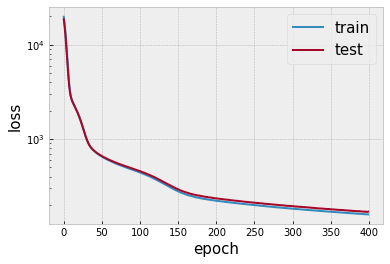

In [55]:

plt.semilogy(train_loss,label='train')
plt.semilogy(test_loss,label='test')
plt.xlabel('epoch',fontsize=15)
plt.ylabel('loss',fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Images/250epochs_loss.pdf')
plt.show()

## Distribution of energies

1638
1638


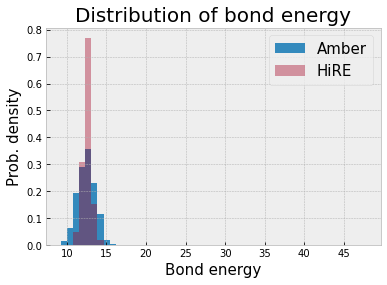

Amber energies: 
Mean: 12.566 
Variance: 3.452
Hire energies: 
Mean: 12.542 
Variance: 0.312


In [59]:
# histogram of amber bond energies

model.load_state_dict(torch.load("data/Results/400_same_order.pth"))
bond_energies = []
bond_computed_energies =[]
for i in range(len(seq_data)):
    en1 = seq_data[i]['features'][0,9]
    with torch.no_grad():
        en2 = model(seq_data[i]).squeeze()[0]
    #if torch.isnan(en2): #or torch.isnan(en2):
    #    continue
    bond_energies.append(en1.item())
    bond_computed_energies.append(en2.item())
print(len(bond_energies))
print(len(bond_computed_energies))

hist1b = plt.hist(bond_energies,bins=50,density=True,label='Amber')
hist2b = plt.hist(bond_computed_energies,bins=hist1b[1],density=True,alpha=0.4,label='HiRE')
plt.xlabel('Bond energy',fontsize=15)
plt.ylabel('Prob. density',fontsize=15)
plt.title('Distribution of bond energy',fontsize=20)
plt.legend(fontsize=15)
# plt.savefig('Images/bond_dist250.pdf')
plt.show()

print('Amber energies: \nMean: {:.3f}'.format(np.array(bond_energies).mean())+' \nVariance: {:.3f}'.format(np.array(bond_energies).var()))
print('Hire energies: \nMean: {:.3f}'.format(np.array(bond_computed_energies).mean())+' \nVariance: {:.3f}'.format(np.array(bond_computed_energies).var()))

1638
1638


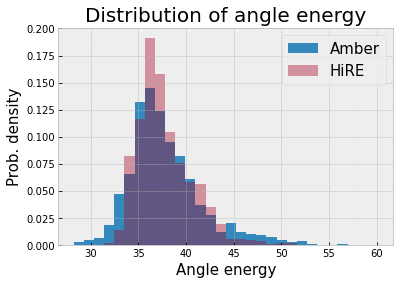

Amber energies: 
Mean: 37.873 
Variance: 15.887
Hire energies: 
Mean: 37.781 
Variance: 8.573


In [60]:
# distribution of angles energy

angle_energies = []
angle_computed_energies =[]
for i in range(len(seq_data)):
    en1 = seq_data[i]['features'][1,9]
    with torch.no_grad():
        en2 = model(seq_data[i]).squeeze()[1]
    # if torch.isnan(en1) or torch.isnan(en2):
    #    continue
    angle_energies.append(en1.item())
    angle_computed_energies.append(en2.item())
print(len(angle_energies))
print(len(angle_computed_energies))

hist1a = plt.hist(angle_energies,bins=30,density=True,label='Amber')
hist2a = plt.hist(angle_computed_energies,bins=hist1a[1],density=True,alpha=0.4,label='HiRE')
plt.xlabel('Angle energy',fontsize=15)
plt.ylabel('Prob. density',fontsize=15)
plt.title('Distribution of angle energy',fontsize=20)
plt.legend(fontsize=15)
# plt.savefig('Images/angle_dist250.pdf')
plt.show()

print('Amber energies: \nMean: {:.3f}'.format(np.array(angle_energies).mean())+' \nVariance: {:.3f}'.format(np.array(angle_energies).var()))
print('Hire energies: \nMean: {:.3f}'.format(np.array(angle_computed_energies).mean())+' \nVariance: {:.3f}'.format(np.array(angle_computed_energies).var()))

1638
1638


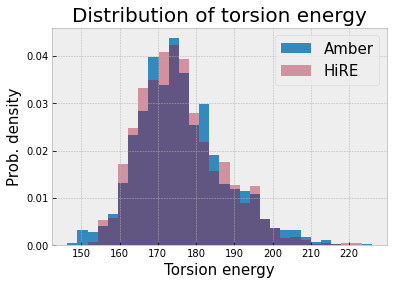

Amber energies: 
Mean: 176.208 
Variance: 131.220
Hire energies: 
Mean: 175.904 
Variance: 116.405


In [61]:
# distribution of torsion energies

torsion_energies = []
torsion_computed_energies =[]
for i in range(len(seq_data)):
    en1 = seq_data[i]['features'][2,9]
    with torch.no_grad():
        en2 = model(seq_data[i]).squeeze()[2]
    # if torch.isnan(en1) or torch.isnan(en2):
    #    continue
    torsion_energies.append(en1.item())
    torsion_computed_energies.append(en2.item())
print(len(torsion_energies))
print(len(torsion_computed_energies))

hist1d = plt.hist(torsion_energies,bins=30,density=True,label='Amber')
hist2d = plt.hist(torsion_computed_energies,bins=hist1d[1],density=True,alpha=0.4,label='HiRE')
plt.xlabel('Torsion energy',fontsize=15)
plt.ylabel('Prob. density',fontsize=15)
plt.title('Distribution of torsion energy',fontsize=20)
plt.legend(fontsize=15)
# plt.savefig('Images/torsion_dist250.pdf')
plt.show()

print('Amber energies: \nMean: {:.3f}'.format(np.array(torsion_energies).mean())+' \nVariance: {:.3f}'.format(np.array(torsion_energies).var()))
print('Hire energies: \nMean: {:.3f}'.format(np.array(torsion_computed_energies).mean())+' \nVariance: {:.3f}'.format(np.array(torsion_computed_energies).var()))

In [58]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([2.1357e-01, 2.0810e+00, 1.5191e+00, 2.3544e+00, 4.1974e+00, 4.5878e+00,
        4.7566e+00, 5.5238e+00, 2.0957e+00, 1.4609e+00, 1.5223e+01, 1.0000e+00,
        2.8000e+00, 2.5050e+00, 1.8260e+00, 3.9320e+00, 4.3090e+00, 4.7750e+00,
        4.5460e+00, 2.8210e+00, 3.8130e+00, 3.0100e+00, 9.0800e-01, 3.0000e+00,
        4.0000e+00, 2.2570e+00, 4.8000e-01, 5.0000e-01, 4.5501e+00, 1.0791e+01,
        1.1136e+01, 5.5788e+00, 2.8008e-01, 5.2426e-01, 4.0776e-01, 7.6815e-01,
        6.3907e-01, 4.0274e-01, 1.2000e+00, 1.5000e+00, 4.0000e-01, 1.8000e+00,
        8.0000e-01, 1.4231e+02, 1.0000e+00, 0.0000e+00, 2.9337e-02],
       requires_grad=True)
Parameter containing:
tensor([[ 29.9104,   3.6152],
        [200.0000,   2.3410],
        [200.0000,   2.6884],
        [200.0000,   2.6600],
        [200.0000,   3.0970],
        [200.0000,   3.1292],
        [200.0000,   2.5736],
        [200.0000,   2.2006],
        [200.0000,   1.4519],
        [200.0000,   1.6986],


In [52]:
print(len(hist2b[0]))
print(hist2b[1])
print(len(hist1b[0]))
print(hist1b[1])

50
[ 9.25585365 10.02447018 10.7930867  11.56170322 12.33031975 13.09893627
 13.8675528  14.63616932 15.40478584 16.17340237 16.94201889 17.71063541
 18.47925194 19.24786846 20.01648499 20.78510151 21.55371803 22.32233456
 23.09095108 23.8595676  24.62818413 25.39680065 26.16541718 26.9340337
 27.70265022 28.47126675 29.23988327 30.00849979 30.77711632 31.54573284
 32.31434937 33.08296589 33.85158241 34.62019894 35.38881546 36.15743198
 36.92604851 37.69466503 38.46328156 39.23189808 40.0005146  40.76913113
 41.53774765 42.30636417 43.0749807  43.84359722 44.61221375 45.38083027
 46.14944679 46.91806332 47.68667984]
50
[ 9.25585365 10.02447018 10.7930867  11.56170322 12.33031975 13.09893627
 13.8675528  14.63616932 15.40478584 16.17340237 16.94201889 17.71063541
 18.47925194 19.24786846 20.01648499 20.78510151 21.55371803 22.32233456
 23.09095108 23.8595676  24.62818413 25.39680065 26.16541718 26.9340337
 27.70265022 28.47126675 29.23988327 30.00849979 30.77711632 31.54573284
 32.31434

In [50]:
import numpy as np

def KL_divergence(hist1,hist2):
    # div(p,q) = sum_x p(x) * log(p(x)/q(x))
    # hist[1]: bin limits
    # hist[0]: y value
    p_x = hist1[0] * np.diff(hist1[1])
    q_x = hist2[0] * np.diff(hist2[1])
    cond = (q_x>0) & (p_x>0)
    div = np.sum( -p_x[cond] * np.log(q_x[cond]/p_x[cond]))
    return div

In [62]:
div_bonds = KL_divergence(hist1b,hist2b)

In [63]:
div_angles = KL_divergence(hist1a,hist2a)
div_tors = KL_divergence(hist1d,hist2d)
print(div_bonds,div_angles,div_tors)

0.2407331925419751 0.08020748477503784 0.015452710529074938


In [26]:
div_angles = KL_divergence(hist1a,hist2a)
div_tors = KL_divergence(hist1d,hist2d)
print(div_bonds,div_angles,div_tors)

0.005716266604174925 0.45486012013793753 0.01813570128719363


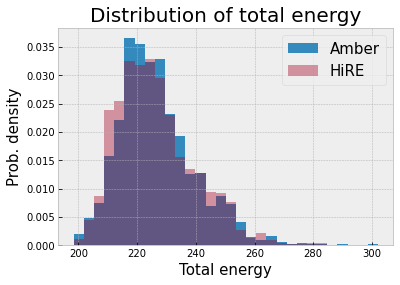

Amber energy: 
Mean: 226.647 
Variance: 170.038
Hire energy: 
Mean: 226.228 
Variance: 173.852


In [64]:
amber_tot = np.array(bond_energies) + np.array(angle_energies) + np.array(torsion_energies)
hire_tot = np.array(bond_computed_energies) + np.array(angle_computed_energies) + np.array(torsion_computed_energies)

hist1tot = plt.hist(amber_tot,bins=30,density=True,label='Amber')
hist2tot = plt.hist(hire_tot,bins=hist1tot[1],density=True,alpha=0.4,label='HiRE')
plt.xlabel('Total energy',fontsize=15)
plt.ylabel('Prob. density',fontsize=15)
plt.title('Distribution of total energy',fontsize=20)
plt.legend(fontsize=15)
# plt.savefig('Images/torsion_dist250.pdf')
plt.show()

print('Amber energy: \nMean: {:.3f}'.format(np.array(amber_tot).mean())+' \nVariance: {:.3f}'.format(np.array(amber_tot).var()))
print('Hire energy: \nMean: {:.3f}'.format(np.array(hire_tot).mean())+' \nVariance: {:.3f}'.format(np.array(hire_tot).var()))

In [65]:
div_tot = KL_divergence(hist1tot,hist2tot)
print(div_tot)

0.015770472758085
